# SpamDetector

## Preprocessing

In [1]:
%run ExtractContent.py TR/ TRAIN/

In [29]:
# Get labels
import string
import csv
labels = list()
with open('spam-mail.tr.label','rb') as f :
    labels_reader = csv.reader(f, delimiter=',')
    count_row = 0

    for row in labels_reader:
        if count_row != 0 :
            labels.append(row[1])
        count_row = count_row + 1
        
class_names = ['Spam', 'Ham']
#print labels

In [5]:
# Get mails
from sklearn.feature_extraction.text import TfidfVectorizer
import codecs

mails = list()
for i in range(1, 2501) :
    with codecs.open('TRAIN/TRAIN_%s.eml'%i, 'r', encoding='utf-8', errors='ignore') as f :
        mail = f.read()
        mails.append(mail)

# Compute TD-IDF features
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
mail_vectors = vectorizer.fit_transform(mails)

In [6]:
# Divise dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mail_vectors, labels, test_size=0.33, random_state=42)


## Machine Learning

### Tools

In [44]:
# Inspired from : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    


### Supervised - Decision tree

In [19]:
# Train model
def decision_tree(max_depth) :
    print "Training Decision Tree model..."
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth) # classifier = learning algorithm that will learn from the training dataset
    model = clf.fit(X_train, y_train) # finds patterns in training data and create a set of rules (the model)
    print "Model trained!"

    training_error = 1-clf.score(X_train, y_train)
    test_error = 1-clf.score(X_test, y_test)
    print "Training error : " + str(training_error)
    print "Test error : " + str(test_error)
    return model.predict(X_test)

In [30]:
y_pred = decision_tree(max_depth=2)

Training Decision Tree model...
Model trained!
Training error : 0.151641791045
Test error : 0.139393939394


In [41]:
y_pred = decision_tree(max_depth=1)

Training Decision Tree model...
Model trained!
Training error : 0.162985074627
Test error : 0.153939393939


Confusion matrix, without normalization


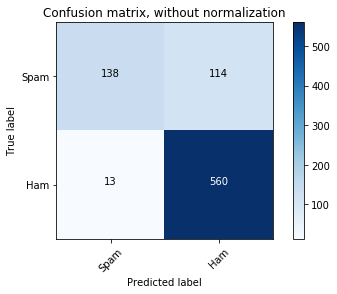

In [45]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

### Supervised - SVM

In [6]:
print "Training SVM Model..."
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
print "Model trained!"

training_error = 1-clf.score(X_train, y_train)
test_error = 1-clf.score(X_test, y_test)
print "Training error : " + str(training_error)
print "Test error : " + str(test_error)


Training SVM Model...
Model trained!
Training error : 0.314626865672
Test error : 0.305454545455
